## Skin Cancer Binary Classification CNN HOTARU v1.22

The following notebook displays how the fifth iteration of the CNN model for skin cancer identification HOTARU was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

HOTARU v1.22, unlike previous versions, is not accompanied by SPARK, as this model serves to determine the performance of SPARK through its absence. 

This model consists of a CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

**Changes done**
- Removed SPARK code and replaced it with only resizing code.

In [1]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomContrast
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage import io, color, exposure
from skimage.filters import threshold_otsu

C:\Users\dalet\AppData\Local\Temp\ipykernel_1288\3595835252.py:12: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Defining datasets, which are already preprocessed prior to feeding to model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data_n/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data_n/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data_n/test', image_size=(300,300), batch_size=32)

Found 6994 files belonging to 2 classes.
Found 874 files belonging to 2 classes.
Found 876 files belonging to 2 classes.


# Creating the CNN part of the model

In [4]:
# Creating Sequential object
cnn = Sequential()

In [5]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [6]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [7]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

# Logging

In [8]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [9]:
hist = cnn.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/20


219/219 [==============================] - 163s 729ms/step - loss: 3.3521 - accuracy: 0.7361 - precision: 0.7392 - recall: 0.8913 - val_loss: 0.4173 - val_accuracy: 0.8398 - val_precision: 0.8546 - val_recall: 0.8954
Epoch 2/20
219/219 [==============================] - 118s 533ms/step - loss: 0.4487 - accuracy: 0.7845 - precision: 0.7825 - recall: 0.9065 - val_loss: 0.3727 - val_accuracy: 0.8112 - val_precision: 0.8094 - val_recall: 0.9119
Epoch 3/20
219/219 [==============================] - 117s 529ms/step - loss: 0.4295 - accuracy: 0.8123 - precision: 0.8090 - recall: 0.9149 - val_loss: 0.4496 - val_accuracy: 0.8158 - val_precision: 0.9120 - val_recall: 0.7798
Epoch 4/20
219/219 [==============================] - 115s 522ms/step - loss: 0.4513 - accuracy: 0.7965 - precision: 0.7989 - recall: 0.9005 - val_loss: 0.4554 - val_accuracy: 0.7757 - val_precision: 0.8939 - val_recall: 0.7266
Epoch 5/20
219/219 [==============================] - 117s 527ms/step - loss: 0.4027 -

# Evaluation - Loss, Accuracy, Precision, Recall and F1-Score

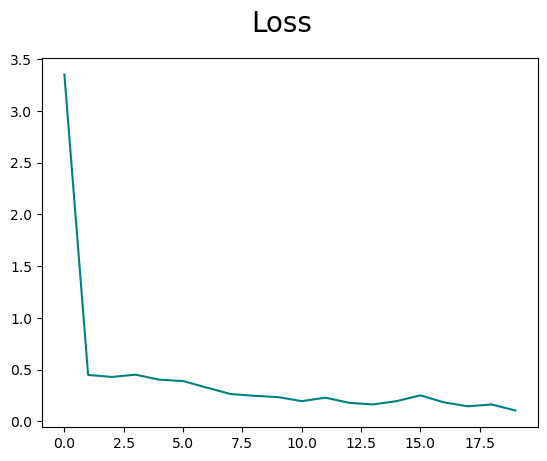

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.show()

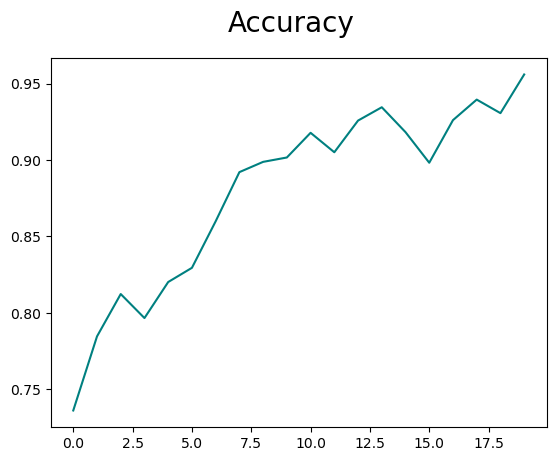

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.show()

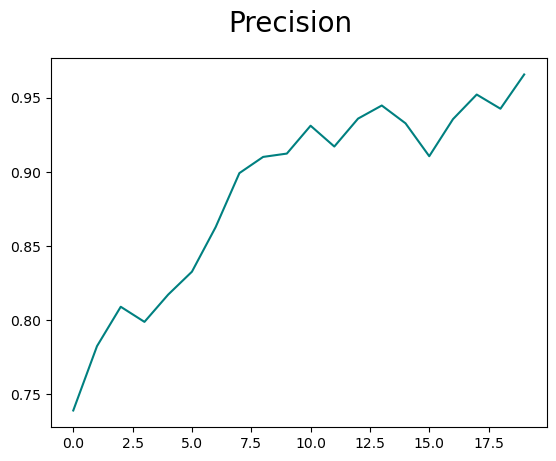

In [12]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='precision')
fig.suptitle('Precision', fontsize=20)
plt.show()

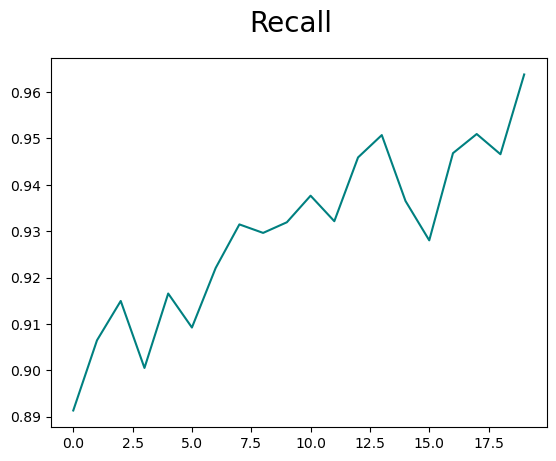

In [13]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
fig.suptitle('Recall', fontsize=20)
plt.show()

In [14]:
# Calculating F1-score for every epoch

f1_score = []

for i in range(len(hist.history['precision'])):
    x = 2 * ((hist.history['precision'][i] * hist.history['recall'][i]) / (hist.history['precision'][i] + hist.history['recall'][i]))
    f1_score.append(x)

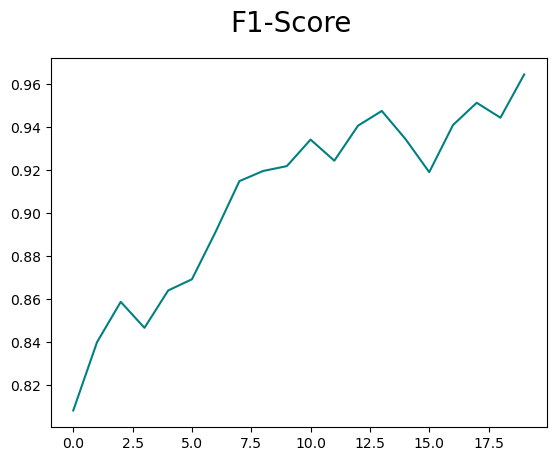

In [15]:
fig = plt.figure()
plt.plot(f1_score, color='teal', label='f1-score')
fig.suptitle('F1-Score', fontsize=20)
plt.show()

# Testing with a batch

In [16]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy, model_precision, model_recall = cnn.evaluate(test_dataset,verbose=1)

# Calculating F1-score manually
f1score = 2 * ((model_precision * model_recall) / (model_precision + model_recall))

# Printing metrics
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}, F1-score: {f1score}")

28/28 [==============================] - 16s 407ms/step - loss: 0.3350 - accuracy: 0.9304 - precision: 0.9292 - recall: 0.9615
Loss: 0.334952712059021, Accuracy: 0.9303653240203857, Precision: 0.9292035102844238, Recall: 0.9615384340286255, F1-score: 0.9450944808836971


In [17]:
# Creating confusion matrix and classification report

# Creating ground truth label list
classes = test_dataset.class_names 
y_true = []

for images, label in test_dataset:   
    for e in label:
        y_true.append(int(classes[e]))

# Creating prediction list
y_pred = cnn.predict(test_dataset)
y_pred = np.round(y_pred).tolist()

# Converting all lists gathered to arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)        

print(" ")
print("Confusion matrix:") 
print("---------------------")
print(cm)
print(" ")

# Generating classification report
clr = classification_report(y_true, y_pred, target_names=classes)

print("Classification Report:") 
print("---------------------")
print(clr)

28/28 [==============================] - 7s 192ms/step
 
Confusion matrix:
---------------------
[[121 209]
 [190 356]]
 
Classification Report:
---------------------
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       330
           1       0.63      0.65      0.64       546

    accuracy                           0.54       876
   macro avg       0.51      0.51      0.51       876
weighted avg       0.54      0.54      0.54       876



#### **Result**

Accuracy of 54-93%, precision of 92.9%, recall of 96.2% and F1-score of 94.5%.

The difference in performance when comparing HOTARU v1.22 and v1.21 is only slight; v1.22 performed a bit better than v1.21, showing that SPARK does not have much impact on HOTARU's ability to classify skinmarks.

# Testing with a single picture / Showcasing SPARK script

In [18]:
# Creating preprocessing function
def prepro(img_path, cmap_type='gray'):
    # Loading in image
    img = Image.open(img_path)
    
    # Resize the image to a consistent size (e.g., 224x224)
    img = img.resize((300, 300))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Show image being used
    plt.imshow(img_array, cmap=cmap_type)
    plt.axis('off')
    plt.show()

    return img_array

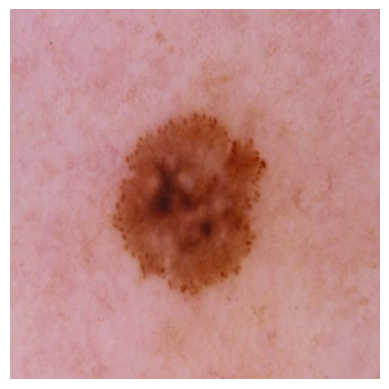

In [19]:
# Feeding model with a photo with a ground truth of having skin cancer

# Preprocessing image
img1 = prepro("img_data_o/test/1/ISIC_0028033.jpg")

In [20]:
# Model prediction
pred1 = cnn.predict(np.expand_dims(img1/255, 0))

if pred1 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred1

1/1 [==============================] - 0s 97ms/step
Skin cancer not detected


array([[5.0572275e-05]], dtype=float32)

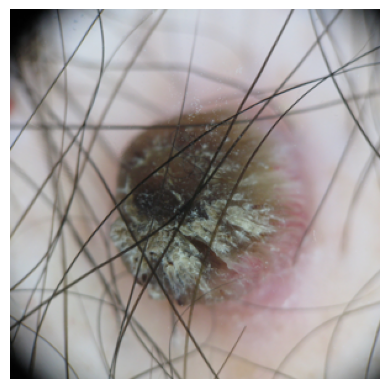

In [21]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Preprocessing image
img2 = prepro("img_data_o/test/0/ISIC_0068219.jpg")

In [22]:
# Model prediction
pred2 = cnn.predict(np.expand_dims(img2/255, 0))

if pred2 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred2

1/1 [==============================] - 0s 38ms/step
Skin cancer not detected


array([[0.]], dtype=float32)

**Results**

Correctly identified skin cancer image, but did not correctly identify non-skin cancer image.

## Saving the model - Save did not occur

In [23]:
# Export our model to HDF5 file
cnn.save("models/prod_4.h5")

C:\Users\dalet\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Exporting model as Pickle file
import pickle

pickle.dump(cnn, open('models/prod_4.pkl', 'wb'))